### Try this notebook in Google Colab, Binder or SageMaker!

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/InsightSoftwareConsortium/itkwidgets/blob/main/examples/integrations/MONAI/transform_visualization.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/InsightSoftwareConsortium/itkwidgets/HEAD?labpath=examples%2Fintegrations%2FMONAI%2Ftransform_visualization.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github.com/InsightSoftwareConsortium/itkwidgets/blob/main/examples/integrations/MONAI/transform_visualization.ipynb)

In [ ]:
# Install dependencies for this example
import sys

!{sys.executable} -m pip install -q "monai[nibabel,itk,matplotlib,tqdm]" "itkwidgets[all]>=1.0a47"

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from monai.utils import first, set_determinism
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
)
from monai.data import DataLoader, Dataset
from monai.apps import download_and_extract
import tempfile
import os
import glob
from itkwidgets import view

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

In [3]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [4]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

In [5]:
set_determinism(seed=0)

In [ ]:
transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="PLS"),
    ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    EnsureTyped(keys=["image", "label"]),
])

In [7]:
check_ds = Dataset(data=data_dicts, transform=transform)
check_loader = DataLoader(check_ds, batch_size=1)

data = first(check_ds)
print(f"image shape: {data['image'].shape}, label shape: {data['label'].shape}")
print(f"image affine: {data['image'].affine},\n label shape: {data['label'].affine}")

image shape: torch.Size([1, 282, 329, 136]), label shape: torch.Size([1, 282, 329, 136])
image affine: tensor([[  0.0000,  -1.5000,   0.0000,   0.4768],
        [ -1.5000,   0.0000,   0.0000, -64.0232],
        [  0.0000,   0.0000,   2.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64),
 label shape: tensor([[  0.0000,  -1.5000,   0.0000,   0.4768],
        [ -1.5000,   0.0000,   0.0000, -64.0232],
        [  0.0000,   0.0000,   2.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64)


The data in the `Dataset` is a `monai` `MetaTensor`, which is a `torch.Tensor` with an additional `.meta` metadata attribute and `.affine` spatial affine matrix.

`itkwidgets` understands this metadata.

In [8]:
print(type(data['image']))
print(f"image shape: {data['image'].shape}, label shape: {data['label'].shape}")
print(f"image affine: {data['image'].affine},\nlabel shape: {data['label'].affine}")

<class 'monai.data.meta_tensor.MetaTensor'>
image shape: torch.Size([1, 282, 329, 136]), label shape: torch.Size([1, 282, 329, 136])
image affine: tensor([[  0.0000,  -1.5000,   0.0000,   0.4768],
        [ -1.5000,   0.0000,   0.0000, -64.0232],
        [  0.0000,   0.0000,   2.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64),
label shape: tensor([[  0.0000,  -1.5000,   0.0000,   0.4768],
        [ -1.5000,   0.0000,   0.0000, -64.0232],
        [  0.0000,   0.0000,   2.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64)



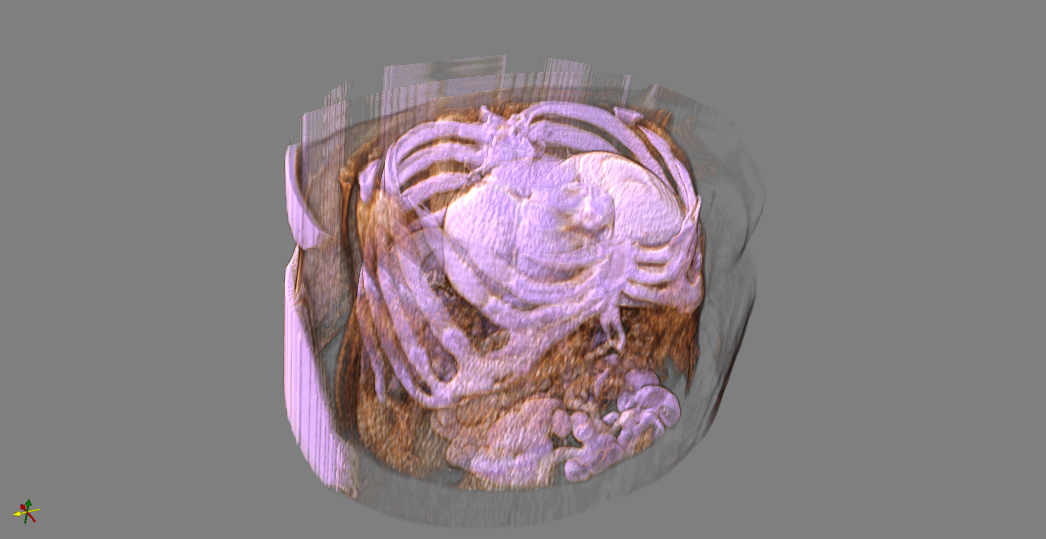
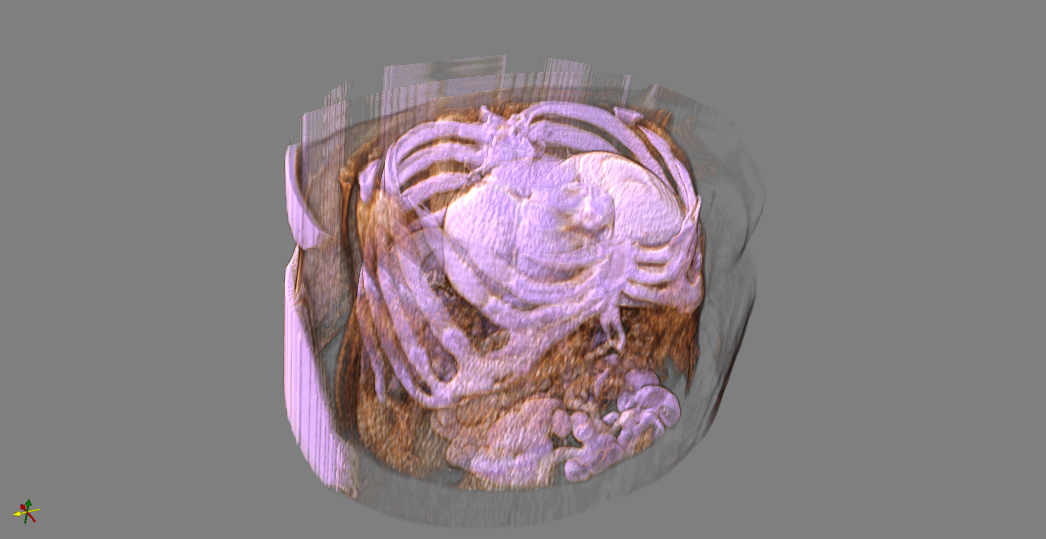

<IPython.core.display.Javascript object>

In [9]:
view(image=data["image"] * 255, gradient_opacity=0.4)


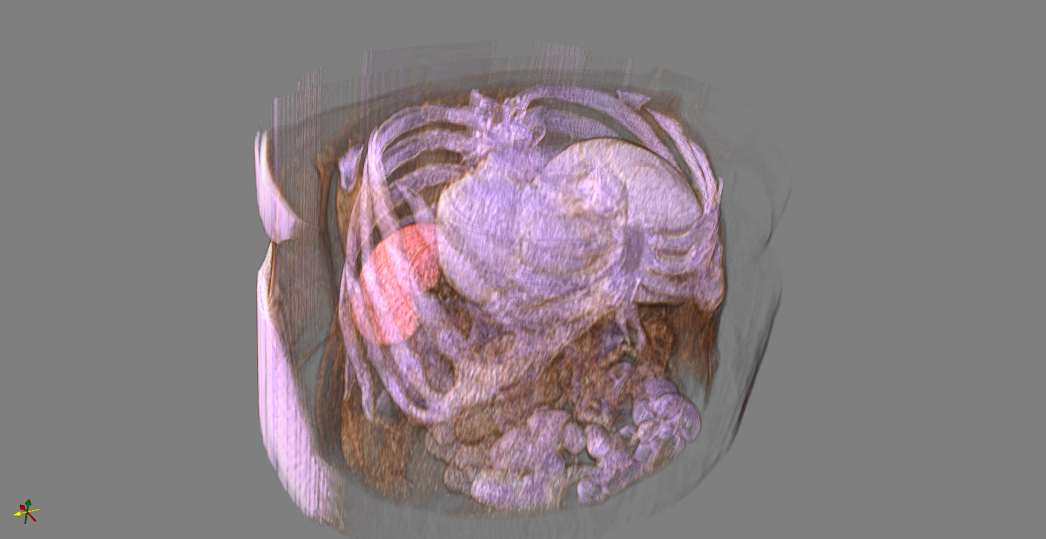
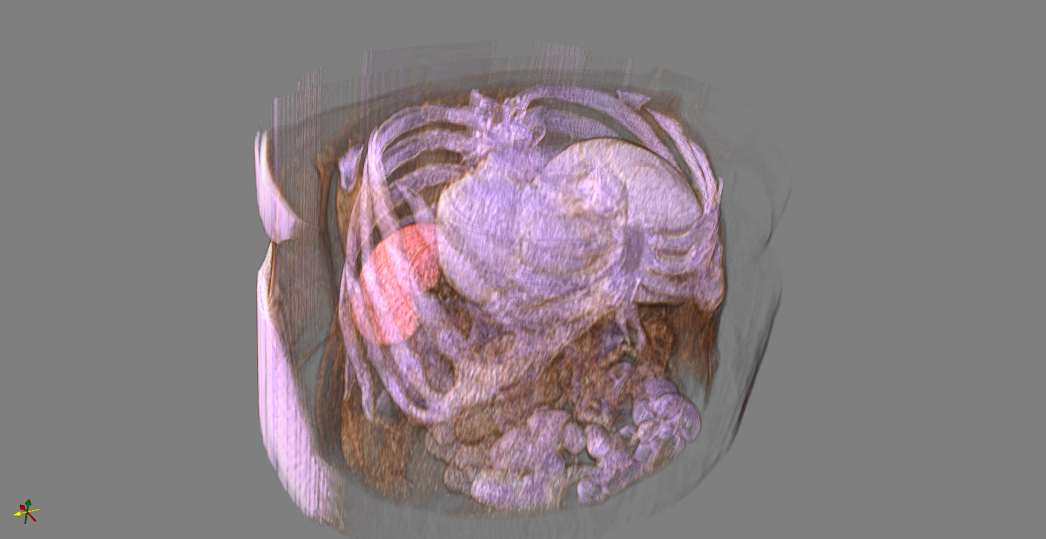

<IPython.core.display.Javascript object>

In [10]:
view(image=data["image"] * 255, label_image=data['label'], gradient_opacity=0.4)